###подключить google drive

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


###Kaggle API

In [0]:
#from google.colab import files
#file = files.upload()


!mkdir ~/.kaggle
!cp /content/drive/My\ Drive/kaggle.json ~/.kaggle
!ls ~/.kaggle


kaggle.json


In [0]:
import random
import numpy as np
import os
from keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, BatchNormalization 
from tensorflow.keras import utils
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import RMSprop
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
import tensorflow as tf
from sklearn.model_selection import train_test_split
from google.colab import files
import matplotlib.pyplot as plt
%matplotlib inline 

from hyperopt import hp, fmin, tpe, hp, STATUS_OK, Trials, space_eval
from hyperopt.mongoexp import MongoTrials

from yellowbrick.classifier import ClassificationReport, ClassPredictionError
from sklearn.base import BaseEstimator, RegressorMixin, ClassifierMixin
from keras.wrappers.scikit_learn import  KerasRegressor, KerasClassifier
from sklearn.metrics import classification_report, confusion_matrix


Using TensorFlow backend.


###Загрузим данные с kaggle и сохраним 

In [0]:
#!kaggle competitions download -c digit-recognizer
#!ls

!mv test.csv /content/drive/My\ Drive/test.csv  
!mv train.csv /content/drive/My\ Drive/train.csv  


#Загрузка и подготовка данных

In [0]:
from numpy.random import seed
seed(13)
from tensorflow import set_random_seed
set_random_seed(666)

fn_train = '/content/drive/My Drive/train.csv'
fn_test = '/content/drive/My Drive/test.csv'

batch_size=256

#prepare train, val, test
train_dataset = np.loadtxt(fn_train, skiprows=1, delimiter=',')
x_train = train_dataset[:, 1:]
y_train = train_dataset[:, 0]
# Переформатируем данные в 2D, бэкенд TensorFlow
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
input_shape = (28, 28, 1)
x_train /= 255.0
y_train = utils.to_categorical(y_train)

random_seed = 2
X_train, X_val, Y_train, Y_val = train_test_split(x_train, y_train, test_size = 0.1, random_state=random_seed)

#для tpu кратно batch_size
#X_train = np.resize(X_train,(X_train.shape[0]//batch_size)*batch_size, 28, 28, 1)
#Y_train = np.resize(X_train,(X_train.shape[0]//batch_size)*batch_size, 10)

test_dataset = np.loadtxt(fn_test, skiprows=1, delimiter=",")
x_test = test_dataset.reshape(test_dataset.shape[0], 28, 28, 1)
x_test = x_test / 255.0

#augmentation
datagen = ImageDataGenerator(
        rotation_range=10,  
        zoom_range = 0.10,  
        width_shift_range=0.1, 
        height_shift_range=0.1)

aug = ImageDataGenerator(rotation_range=25, width_shift_range=0.1,
	height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
	horizontal_flip=True, fill_mode="nearest")



In [0]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)


(42000, 28, 28, 1)
(42000, 10)
(28000, 28, 28, 1)


#Вспомогательные функции

In [0]:
#параметры оптимизации
space = { 'batch_size' : hp.choice('batch_size', [128,256]), 
          'activation' : hp.choice('activation', ['relu','elu']), 
          'optimizer' : hp.choice('optimizer', ['nadam', 'rmsprop']), 
          'drop1' : hp.choice('drop1', [.3,.4,.5]), 
          'drop2' : hp.choice('drop2', [.3,.4,.5]), 
          'nb_neurons' : hp.choice('nb_neurons', [128,192,224,256]), 
        }

def callbacks():
  сheckpoint = ModelCheckpoint('mnist-cnn.hdf5', 
                                monitor='val_acc', 
                                save_best_only=True,
                                verbose=0)
  learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                              patience=3, 
                                              verbose=0, 
                                              factor=0.5, 
                                              min_lr=0.00001)
  earlystop = EarlyStopping(monitor='val_acc', min_delta=0.001, patience=5,verbose=0, mode='auto')
  
  return [сheckpoint,learning_rate_reduction,earlystop]

#модель сети
def create_model(params, nb_classes=10, TPU=False):
  model = Sequential()
  model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', activation =params['activation'], input_shape = (28,28,1)))
  model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', activation =params['activation']))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(params['drop1']))


  model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation =params['activation']))
  model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation =params['activation']))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
  model.add(Dropout(params['drop1']))

  model.add(Flatten())
  model.add(Dense(params['nb_neurons'], activation = params['activation']))
  model.add(Dropout(params['drop2']))
  model.add(Dense(nb_classes, activation = "softmax"))

  if TPU == True:
    model = tf.contrib.tpu.keras_to_tpu_model(
          model,
          strategy=tf.contrib.tpu.TPUDistributionStrategy(
              tf.contrib.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
          )
      )

  model.compile(loss="categorical_crossentropy", optimizer=params['optimizer'], metrics=["accuracy"])  
  
  return model

#целевая функция минимизации (для поиска гиперпараметров)
def objective(params):
  model = create_model(params)
  

  if os.path.isfile('mnist-cnn.hdf5'):
    os.remove('mnist-cnn.hdf5')  


  #augmentation
  datagen = ImageDataGenerator(
        rotation_range=10,  
        zoom_range = 0.10,  
        width_shift_range=0.1, 
        height_shift_range=0.1)
  

  model.fit(datagen.flow(X_train, Y_train, batch_size=params['batch_size']),
          epochs=10000,  # using early stopping, so no real limit
          verbose=1,
          validation_data=(X_val, Y_val),
          callbacks=callbacks())
            
  model.load_weights('mnist-cnn.hdf5')

            
  score = model.evaluate(X_val, Y_val, verbose=0)

  validation_acc = score[1]
  print(params)
  print('validation acc:', validation_acc)
  return {'loss': -validation_acc, 'status': STATUS_OK, 'model': model}                    


#для воспроизводимости, хотя и не работает для GPU
# https://keras.io/getting-started/faq/#how-can-i-obtain-reproducible-results-using-keras-during-development
def setseed(seed=13):
  os.environ['PYTHONHASHSEED']=str(0)
  
  # The below is necessary for starting Numpy generated random numbers
  # in a well-defined initial state.

  np.random.seed(42)

  # The below is necessary for starting core Python generated random numbers
  # in a well-defined state.

  random.seed(seed)

  # Force TensorFlow to use single thread.
  # Multiple threads are a potential source of non-reproducible results.
  # For further details, see: https://stackoverflow.com/questions/42022950/

  session_conf = tf.ConfigProto(intra_op_parallelism_threads=1,
                                inter_op_parallelism_threads=1)

  from keras import backend as K

  # The below tf.set_random_seed() will make random number generation
  # in the TensorFlow backend have a well-defined initial state.
  # For further details, see:
  # https://www.tensorflow.org/api_docs/python/tf/set_random_seed

  tf.set_random_seed(seed)

  sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
  K.set_session(sess)

#Поиск гиперпараметров

In [0]:

setseed()
trials = Trials()
best = fmin(objective, space, algo=tpe.suggest, trials=trials, max_evals=30)

print (best)
print (trials.best_trial)


Epoch 1/10000
148/148 [==============================] - 16s 111ms/step - loss: 0.9513 - acc: 0.7790 - val_loss: 0.1339 - val_acc: 0.9574
Epoch 2/10000
148/148 [==============================] - 13s 86ms/step - loss: 0.2330 - acc: 0.9313 - val_loss: 0.1059 - val_acc: 0.9698
Epoch 3/10000
148/148 [==============================] - 13s 88ms/step - loss: 0.1706 - acc: 0.9490 - val_loss: 0.0474 - val_acc: 0.9840
Epoch 4/10000
148/148 [==============================] - 13s 89ms/step - loss: 0.1396 - acc: 0.9590 - val_loss: 0.0557 - val_acc: 0.9810
Epoch 5/10000
148/148 [==============================] - 14s 93ms/step - loss: 0.1284 - acc: 0.9625 - val_loss: 0.0563 - val_acc: 0.9836
Epoch 6/10000
148/148 [==============================] - 13s 91ms/step - loss: 0.1102 - acc: 0.9682 - val_loss: 0.0399 - val_acc: 0.9855
Epoch 7/10000
148/148 [==============================] - 13s 89ms/step - loss: 0.0978 - acc: 0.9716 - val_loss: 0.0488 - val_acc: 0.9845
Epoch 8/10000
148/148 [=================

#Сохранение оптимальной модели

In [0]:
fn_best_model = '/content/drive/My Drive/best-mnist-cnn.hdf5'

trials.best_trial['result']['model'].save_weights(fn_best_model)

model = create_model(space_eval(space, best))
model.load_weights(fn_best_model)
score = model.evaluate(X_val, Y_val, verbose=0)

validation_acc = score[1]
print('validation acc:', validation_acc)

#trials.best_trial


#Визуализация ошибки распознавания по классам

In [0]:
def keras_model():
  model = create_model(params)
  return model


class KerasClf(BaseEstimator, ClassifierMixin, KerasClassifier):
    def __init__(self, build_fn, **kwargs):
        super(KerasClassifier, self).__init__(build_fn,  **kwargs)
        
    def load_model(self, fn_model, classes):          
      self.classes_ = np.array(classes)
      self.n_classes_ = len(self.classes_)      
      
      self.model = self.build_fn(**self.filter_sk_params(self.build_fn))
      self.model.load_weights(fn_model)
      
      
    def fit(self, x, y, sample_weight=None, **kwargs):    
      y = np.array(y)
      if len(y.shape) == 2 and y.shape[1] > 1:
          self.classes_ = np.arange(y.shape[1])
      elif (len(y.shape) == 2 and y.shape[1] == 1) or len(y.shape) == 1:
          self.classes_ = np.unique(y)
          y = np.searchsorted(self.classes_, y)
      else:
          raise ValueError('Invalid shape for y: ' + str(y.shape))
      self.n_classes_ = len(self.classes_)      
      
      self.model = self.build_fn(**self.filter_sk_params(self.build_fn))
      
      loss_name = self.model.loss
      if hasattr(loss_name, '__name__'):
        loss_name = loss_name.__name__
      if loss_name == 'categorical_crossentropy' and len(y.shape) != 2:
        y = to_categorical(y)

      
      datagen = ImageDataGenerator(
        rotation_range=10,  
        zoom_range = 0.10,  
        width_shift_range=0.1, 
        height_shift_range=0.1)
      
      history = self.model.fit(datagen.flow(x, y, batch_size=params['batch_size']),      
          epochs=100,  # using early stopping, so no real limit
          verbose=1,
          validation_data=(X_val, Y_val),
          callbacks=callbacks())
      self.model.load_weights('mnist-cnn02.hdf5')
      
      return history
            

In [0]:
#параметры модели выбранные оптимизацией
params = {'activation': 'relu', 'batch_size': 256, 'drop1': 0.5, 'drop2': 0.4, 'nb_neurons': 128, 'optimizer': 'nadam'}
      
      
def tf_model():
  model = create_model(params)
  return model

classes=[0,1,2,3,4,5,6,7,8,9]
kf = KerasClf(tf_model)
visualizer = ClassPredictionError(kf)
#visualizer = ClassificationReport(kf, classes=[0,1,2,3,4,5,6,7,8,9])

#setseed()
#np.random()
#history = visualizer.fit(X_train, Y_train)
fn_best_model = '/content/drive/My Drive/best-mnist-cnn.hdf5'
visualizer.load_model(fn_model=fn_best_model, classes= classes)


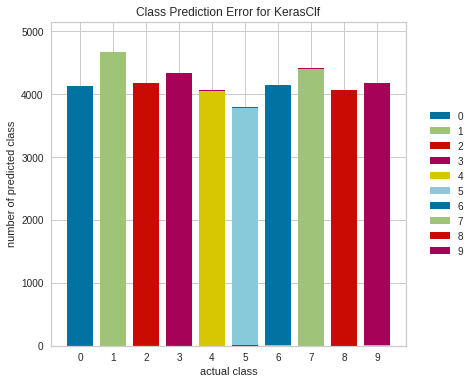

In [0]:
#visualizer.score(X_val, np.argmax(Y_val,axis=1))  # Evaluate the model on the test data
#g = visualizer.poof()

visualizer.score(np.append(X_train,X_val,axis=0), np.argmax(np.append(Y_train,Y_val,axis=0),axis=1))  # Evaluate the model on the test data
g = visualizer.poof()


#Матрица ошибок


In [0]:
y_true = np.argmax(np.append(Y_train,Y_val,axis=0), axis=1)
predicted_classes = visualizer.estimator.model.predict_classes(np.append(X_train,X_val,axis=0))

from sklearn.metrics import classification_report, confusion_matrix
target_names = ["Class {}".format(i) for i in range(10)]
print(classification_report(y_true, predicted_classes, target_names=target_names))
print(confusion_matrix(y_true=y_true, y_pred=predicted_classes, labels=visualizer.classes_))

              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00      4132
     Class 1       1.00      1.00      1.00      4684
     Class 2       1.00      1.00      1.00      4177
     Class 3       1.00      1.00      1.00      4351
     Class 4       1.00      1.00      1.00      4072
     Class 5       1.00      1.00      1.00      3795
     Class 6       1.00      1.00      1.00      4137
     Class 7       1.00      1.00      1.00      4401
     Class 8       1.00      1.00      1.00      4063
     Class 9       1.00      0.99      0.99      4188

   micro avg       1.00      1.00      1.00     42000
   macro avg       1.00      1.00      1.00     42000
weighted avg       1.00      1.00      1.00     42000

[[4131    0    0    0    0    0    1    0    0    0]
 [   0 4669    1    1    1    0    1    9    2    0]
 [   0    1 4171    0    0    0    0    3    2    0]
 [   0    0    2 4339    0    5    0    1    3    1]
 [   0    2    0    0 4056   

In [0]:
predicted_classes

array([8, 7, 9, ..., 2, 2, 6])

#Ошибки по классам

In [0]:
correct = np.nonzero(predicted_classes==y_true)[0]
incorrect = np.nonzero(predicted_classes!=y_true)[0]
true_cl = y_true[incorrect]
false_cl = predicted_classes[incorrect]
#print(true_cl)
#print(false_cl)
#
for cl in visualizer.classes_:
  print('expected:',cl,' predicted:',false_cl[np.where(true_cl==cl)])
  
print()

for cl in visualizer.classes_:
  print('predicted:',cl,' expected:',true_cl[np.where(false_cl==cl)])


expected: 0  predicted: [6]
expected: 1  predicted: [7 7 7 7 6 4 7 7 7 2 7 8 7 3 8]
expected: 2  predicted: [8 7 7 1 8 7]
expected: 3  predicted: [5 2 7 5 5 8 5 9 2 5 8 8]
expected: 4  predicted: [9 6 1 9 9 9 9 9 9 9 1 7 9 9 9 6]
expected: 5  predicted: [8 8 3 6 6 0 6 6 8 6 3 6]
expected: 6  predicted: [8 5 4 0 1]
expected: 7  predicted: [1 1 2 9 2 2 1 9 1 2 1]
expected: 8  predicted: [6 2 9 9 3 2 3 7 9 0 6 5 9 9]
expected: 9  predicted: [4 7 3 4 4 7 4 5 4 4 4 8 4 4 4 2 8 4 7 0 7 8 7 4 4]

predicted: 0  expected: [6 8 5 9]
predicted: 1  expected: [7 4 7 7 4 2 7 7 6]
predicted: 2  expected: [8 7 7 7 3 8 9 1 7 3]
predicted: 3  expected: [9 5 8 8 1 5]
predicted: 4  expected: [9 9 9 9 9 6 9 9 1 9 9 9 9 9 9]
predicted: 5  expected: [3 9 6 3 3 3 8 3]
predicted: 6  expected: [8 4 5 1 5 5 8 0 5 5 5 4]
predicted: 7  expected: [1 9 1 1 9 3 2 8 1 4 2 1 1 1 2 1 9 1 9 9]
predicted: 8  expected: [6 5 5 2 3 9 2 9 1 5 9 1 3 3]
predicted: 9  expected: [4 4 4 4 4 7 4 4 8 8 4 8 7 4 3 8 8 4 4]



###класс 1 неправильно классифицируется с классом 7
###неправильно распознаются между собой классы 4 и 9 


#Классифицируем тестовые данные

In [0]:
'''
model = create_model(params)
history = model.fit(datagen.flow(X_train, Y_train, batch_size=params['batch_size']),      
    epochs=100,  # using early stopping, so no real limit
    verbose=1,
    validation_data=(X_val, Y_val),
    callbacks=callbacks())

model.load_weights('mnist-cnn02.hdf5')  
model.evaluate(X_val, Y_val)
predictions = model.predict_classes(x_test)
'''

predictions = visualizer.estimator.model.predict_classes(x_test)

In [0]:
predictions[0:10]

array([2, 0, 9, 0, 3, 7, 0, 3, 0, 3])

In [0]:
#ф вырезает из тренировочных данных 2 класса, тренирует на них модель и предсказывает эти классы на тестовых данных
#return (индексы предсказанных классов, класс) для тестовой выборки
def fit_predict(ix_train,ix_val,cond_args,nb_classes= 2, params=params, len_seed = 10):
  print(params)
  from shutil import copyfile
    
  #вырезаем данные по данным классам
  x = X_train[ix_train]
  y = np.argmax(Y_train[ix_train],axis=1)
  
  #преобразуем в категориальные данные вектор правильных ответов
  conditions = [y == cond_args[0], y == cond_args[1]]
  choices = [0,1]
  y = utils.to_categorical(np.select(conditions, choices))
  
  #тоже самое для валидационной выборки
  xv = X_val[ix_val]
  yv = np.argmax(Y_val[ix_val],axis=1)

  conditions = [yv == cond_args[0], yv == cond_args[1]]
  yv = utils.to_categorical(np.select(conditions, choices))
  
  #подбор seed
  setseed()
  seeds = np.random.randint(0,100000000,len_seed)
  max_acc = 0
  train_acc = 0
  #тренируем модель делаем предсказание  
  for i in range(len(seeds)):
    model = create_model(params, nb_classes= nb_classes)
    setseed(seeds[i])
    history = model.fit(datagen.flow(x, y, batch_size=params['batch_size']),      
        epochs=100,  # using early stopping, so no real limit
        verbose=1,
        validation_data=(xv, yv),
        callbacks=callbacks())
    #сохраним лучшую модель
    mx = np.argmax(history.history['val_acc'])
    if (history.history['val_acc'][mx] >= max_acc) & (history.history['acc'][mx] > train_acc):
      max_acc = history.history['val_acc'][mx]
      train_acc = history.history['acc'][mx]
      print('max accuracy:',max_acc)
      copyfile('mnist-cnn.hdf5', 'bs_mnist-cnn.hdf5')
  
  model = create_model(params, nb_classes= nb_classes)
  model.load_weights('bs_mnist-cnn.hdf5')  
  
  ix_pred = np.where(np.isin(predictions, cond_args))
  return (ix_pred,model.predict_classes(x_test[ix_pred]))

 

###индексы неправильно распознанных классов обучающей выборки

In [0]:
ix17_train = np.where(np.isin(np.argmax(Y_train,axis=1), [1,7]))
ix17_val = np.where(np.isin(np.argmax(Y_val,axis=1), [1,7]))

ix49_train = np.where(np.isin(np.argmax(Y_train,axis=1), [4,9]))
ix49_val = np.where(np.isin(np.argmax(Y_val,axis=1), [4,9]))

print(np.argmax(Y_train,axis=1)[ix49_train])
print(np.argmax(Y_val,axis=1)[ix49_val])


#Строим модели на основе неправильно классифицированных данных

##Предсказываем класс 1 на тренировочных данных класса 1 и 7

In [0]:

ix, pred = fit_predict(ix17_train,ix17_val,[1,7])

conditions = [pred == 0, pred == 1]
pred17 = np.select(conditions, [1,7])
predictions[ix[0][pred17==1]] = 1




{'activation': 'relu', 'batch_size': 256, 'drop1': 0.5, 'drop2': 0.4, 'nb_neurons': 192, 'optimizer': 'nadam'}
Epoch 1/100
32/32 [==============================] - 24s 752ms/step - loss: 0.3504 - acc: 0.9306 - val_loss: 0.4386 - val_acc: 0.9925
Epoch 2/100
32/32 [==============================] - 2s 72ms/step - loss: 0.0241 - acc: 0.9910 - val_loss: 0.3995 - val_acc: 0.9850
Epoch 3/100
32/32 [==============================] - 3s 93ms/step - loss: 0.0195 - acc: 0.9936 - val_loss: 0.3344 - val_acc: 0.9979
Epoch 4/100
32/32 [==============================] - 3s 89ms/step - loss: 0.0180 - acc: 0.9944 - val_loss: 0.2898 - val_acc: 0.9893
Epoch 5/100
32/32 [==============================] - 3s 90ms/step - loss: 0.0202 - acc: 0.9941 - val_loss: 0.2170 - val_acc: 0.9968
Epoch 6/100
32/32 [==============================] - 3s 92ms/step - loss: 0.0241 - acc: 0.9902 - val_loss: 0.1734 - val_acc: 0.9989
Epoch 7/100
32/32 [==============================] - 3s 88ms/step - loss: 0.0143 - acc: 0.9955 

##Предсказываем классы 4 и 9

In [0]:
p = params
p['nb_neurons'] = 192
ix, pred = fit_predict(ix49_train,ix49_val,[4,9], 2, p, 10)


conditions = [pred == 0, pred == 1]
pred49 = np.select(conditions, [4,9])
predictions[ix[0]] = pred49


{'activation': 'relu', 'batch_size': 256, 'drop1': 0.5, 'drop2': 0.4, 'nb_neurons': 192, 'optimizer': 'nadam'}
Epoch 1/100
29/29 [==============================] - 26s 902ms/step - loss: 0.7357 - acc: 0.7364 - val_loss: 0.5724 - val_acc: 0.9759
Epoch 2/100
29/29 [==============================] - 2s 71ms/step - loss: 0.1409 - acc: 0.9528 - val_loss: 0.5055 - val_acc: 0.9770
Epoch 3/100
29/29 [==============================] - 3s 88ms/step - loss: 0.0626 - acc: 0.9801 - val_loss: 0.4450 - val_acc: 0.9816
Epoch 4/100
29/29 [==============================] - 3s 88ms/step - loss: 0.0662 - acc: 0.9789 - val_loss: 0.4288 - val_acc: 0.9862
Epoch 5/100
29/29 [==============================] - 2s 85ms/step - loss: 0.0514 - acc: 0.9842 - val_loss: 0.4174 - val_acc: 0.9575
Epoch 6/100
29/29 [==============================] - 2s 86ms/step - loss: 0.0492 - acc: 0.9848 - val_loss: 0.3561 - val_acc: 0.9862
Epoch 7/100
29/29 [==============================] - 15s 508ms/step - loss: 0.0465 - acc: 0.984

In [0]:

#p = predictions

print(np.count_nonzero(predictions==4))
print(np.count_nonzero(predictions==9))
p = np.copy(predictions)
print(p[ix[0]])
print(pred49)
p[ix[0]] = pred49
print(np.count_nonzero(p==4))
print(np.count_nonzero(p==9))

print(np.array_equal(predictions,p))
print(np.array_equal(p[ix[0]],pred49))
print(predictions[0:10])
print(p[0:10])
params


2760
2763
[9 4 4 ... 9 9 9]
[9 4 4 ... 9 9 9]
2747
2776
False
True
[2 0 9 0 3 7 0 3 0 3]
[2 0 9 0 3 7 0 3 0 3]


{'activation': 'relu',
 'batch_size': 256,
 'drop1': 0.5,
 'drop2': 0.4,
 'nb_neurons': 192,
 'optimizer': 'nadam'}

#Готовим файл с решением для Kaggle

In [0]:
out = np.column_stack((range(1, predictions.shape[0]+1), predictions))
np.savetxt('submission.csv', out, header="ImageId,Label", comments="", fmt="%d,%d")
!head submission.csv

ImageId,Label
1,2
2,0
3,9
4,0
5,3
6,7
7,0
8,3
9,0


#Отправляем решение 

In [0]:
!kaggle competitions submit -c digit-recognizer -m "Submition from Colab" -f submission.csv

100% 208k/208k [00:10<00:00, 19.9kB/s]
Successfully submitted to Digit Recognizer

#Результат модели с учетом коррекции ошибок неправильно распознанных классов 0.99571

#решение первоначальной модели без учета коррекции, результат 0.99557


In [0]:
predictions = visualizer.estimator.model.predict_classes(x_test)
out = np.column_stack((range(1, predictions.shape[0]+1), predictions))
np.savetxt('submission.csv', out, header="ImageId,Label", comments="", fmt="%d,%d")
!head submission.csv



ImageId,Label
1,2
2,0
3,9
4,0
5,3
6,7
7,0
8,3
9,0


In [0]:
!kaggle competitions submit -c digit-recognizer -m "Submition from Colab" -f submission.csv

100% 208k/208k [00:11<00:00, 18.7kB/s]
Successfully submitted to Digit Recognizer

#Вывод
Для распознавание mnist была взята сверточная сеть, структура находится в процедуре create_model.  Произвел подбор гиперпараметров сети в помощью библиотеки hyperopt. Лучший результат дала модель с параметрами params = {'activation': 'relu', 'batch_size': 256, 'drop1': 0.5, 'drop2': 0.4, 'nb_neurons': 128, 'optimizer': 'nadam'}


На основе ошибок модели на тренировочных данных произведена попытка предсказывать чаcть классов отдельными моделями под каждый набор неправильно классифицируемых классов.
оптимизированная модель неправильно классифицирует 1 классом 7, а также неправильно распознаются между собой классы 4 и 9
Отдельно натренированные на данных классах модели дали небольшое улучшение 0.99571 против 0.9957, для тестовых данных на kaggle liderboard

Данный метод можно использовать в дальнейшем для улучшения кач-ва распознавания. 

В целях улучшения данного метода также можно произвести оптимизацию гиперпараметров отдельных моделей.

Также не успел пропробовать стандартизацию входных данных, кастомная имплементацию дропаут https://github.com/andry9454/KerasDropconnect , не произвел подбор глубины сети. 

На kaggle удалось достичь 220 места.


In [0]:
!pip3 list
